In [1]:
import pickle
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Utils

In [2]:
# File utils


def get_max_run_dir_with_checkpoint(path: Path):
    """Return the directory with the highest run ID that contains a checkpoint.

    If there are no directories with a checkpoint, return None.
    """
    run_dirs = [
        d for d in path.iterdir() if d.name.isdigit() and any(d.glob("checkpoint_*"))
    ]
    if not run_dirs:
        return None

    return max(
        run_dirs,
        key=lambda d: int(d.name),
    )


def get_checkpoint_paths(run_dir, checkpoints_to_eval, no_eval_results=False):
    """Return checkpoint paths to evaluate.

    Args:
        run_dir: Path to the run directory in which checkpoints are stored.
        checkpoints_to_eval: List of checkpoint numbers to evaluate.
        no_eval_results: If True, only return checkpoints that do not have
            evaluation results. Otherwise, return all checkpoints.
    """
    checkpoint_paths = []
    for checkpoint in checkpoints_to_eval:
        checkpoint_path = run_dir / f"checkpoint_{str(checkpoint).zfill(6)}"
        if checkpoint_path.exists():
            if not no_eval_results or not any(
                checkpoint_path.glob("**/episode_results.pickle")
            ):
                checkpoint_paths.append(checkpoint_path)
    return checkpoint_paths

# Start eval runs

In [3]:
base_dir = Path(
    "/nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/MbagAlphaZero/2_players/11x10x10/craftassist/teleportation_False/inf_blocks_True/human_bc_combined_20240903_20"
)
exp_dirs = list(base_dir.glob("**/2024-09-*"))
run_dirs = [get_max_run_dir_with_checkpoint(exp_dir) for exp_dir in exp_dirs]
run_dirs = [d for d in run_dirs if d is not None]

In [4]:
# Evaluate every 100 checkpoints.
checkpoints_to_eval = list(range(100, 2100, 100))
no_eval_results = True

checkpoint_paths = []
for run_dir in run_dirs:
    checkpoint_paths += get_checkpoint_paths(
        run_dir, checkpoints_to_eval, no_eval_results=no_eval_results
    )

# Check that no evaluation results exist if no_eval_results is True.
if no_eval_results:
    for path in checkpoint_paths:
        assert not any(path.glob("**/episode_results.pickle"))

len(checkpoint_paths)

32

In [5]:
# Print evaluation commands.

qos = "scavenger"
partition = "scavenger" if qos == "scavenger" else None

for checkpoint_path in checkpoint_paths:
    if not checkpoint_path.exists():
        raise FileNotFoundError(checkpoint_path)

    partition_str = "" if partition is None else f" --partition={partition}"
    requeue_str = " --requeue" if qos == "scavenger" else ""
    print(
        f"CHECKPOINT={checkpoint_path} sbatch --qos={qos}{partition_str}{requeue_str} scripts/slurm_eval_goal_pred.sh",
        end="\n\n",
    )

CHECKPOINT=/nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/MbagAlphaZero/2_players/11x10x10/craftassist/teleportation_False/inf_blocks_True/human_bc_combined_20240903_20/batch_4096/horizon_1500/truncate_episodes/rollout_64/sgd_minibatch_512/replay_32768/train_1x64/model_replay_131072/max_seq_len_64/gamma_0.95/lr_0.0001/weight_decay_0/model_6x64/no_sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/embedding_size_16/position_embedding_size_48/position_embedding_angle_10/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/463435/2024-09-12_19-16-05/1/checkpoint_000100 sbatch --qos=scavenger --partition=scavenger --requeue scripts/slurm_eval_goal_pred.sh

CHECKPOINT=/nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/MbagAlphaZero/2_players/11x10x10/craftassist/teleportation_False/inf_blocks_True/human_bc_combined_20240903_20/batch_4096/horizon_1500/truncate_episodes/rollout_6

# Plots

## Utils

In [26]:
# Utils


def get_params_from_checkpoint_path(checkpoint_path):
    param_prefixes = [
        "batch",
        "horizon",
        "rollout",
        "sgd_minibatch",
        "replay",
        "model_replay",
        "train",
        "max_seq_len",
        "gamma",
        "lr",
        "weight_decay",
        "model",
        "dim_feedforward",
        "num_heads",
        "norm_first",
        "embedding_size",
        "position_embedding_size",
        "position_embedding_angle",
        "grad_clip",
        "prev_goal_kl",
        "goal_loss_coeff",
        "vf_loss_coeff",
        "other_agent_action_predictor_loss_coeff",
    ]
    params = {}

    for part in checkpoint_path.parts:
        for prefix in param_prefixes:
            if part.startswith(prefix):
                params[prefix] = part.split(prefix + "_")[1]
                break

        if part == "interleave_lstm":
            params["interleave_lstm"] = True
        elif "sep_transformer" in part:
            # True for "sep_transformer" and False for "no_sep_transformer"
            params["sep_transformer"] = part.startswith("sep_transformer")

    if "interleave_lstm" not in params:
        params["interleave_lstm"] = False

    return params


def episode_results_to_df(episode_results):
    common_keys = ("cross_entropy", "cross_entropy_different")
    per_agent_keys = (
        "cross_entropy_by_last_interacted",
        "cross_entropy_different_by_last_interacted",
    )
    rows = []
    for i, episode in enumerate(episode_results):
        common_row_dict = {key: episode[key] for key in common_keys}
        common_row_dict["episode"] = i
        agent_ids = []
        for key in per_agent_keys:
            agent_ids.extend(list(episode[key].keys()))
        agent_ids = set(agent_ids)
        for agent_id in agent_ids:
            row_dict = common_row_dict.copy()
            row_dict["agent_id"] = agent_id
            for key in per_agent_keys:
                row_dict[key] = episode[key][agent_id]
            rows.append(row_dict)

    return pd.DataFrame(rows)


def get_date_from_eval_path(eval_path):
    date_str = eval_path.parts[-3][len("evaluate_on_") :].split("_")[-1]
    return datetime.strptime(date_str, "%Y-%m-%d").date()


def load_goal_pred_dfs_for_checkpoint(checkpoint_path):
    checkpoint_path = Path(checkpoint_path)
    episode_results_paths = list(
        checkpoint_path.glob("evaluate_on_*/*/episode_results.pickle")
    )

    if not episode_results_paths:
        return []

    paths_and_dates = [
        (path, get_date_from_eval_path(path)) for path in episode_results_paths
    ]
    max_date = max([date for _, date in paths_and_dates])
    episode_results_paths = [path for path, date in paths_and_dates if date == max_date]

    max_run_id_per_eval = {}
    for path in episode_results_paths:
        parts = path.parts
        eval_id = parts[-3]
        run_id = int(parts[-2])
        if eval_id not in max_run_id_per_eval:
            max_run_id_per_eval[eval_id] = run_id
        else:
            max_run_id_per_eval[eval_id] = max(max_run_id_per_eval[eval_id], run_id)

    dfs = []
    for eval_id, run_id in max_run_id_per_eval.items():
        episode_result_path = (
            checkpoint_path / eval_id / str(run_id) / "episode_results.pickle"
        )

        with open(episode_result_path, "rb") as f:
            episode_results = pickle.load(f)
        df = episode_results_to_df(episode_results)
        df["split"] = episode_result_path.parts[-3][len("evaluate_on_") :].split("_")[0]

        df["checkpoint"] = int(checkpoint_path.stem.split("_")[1])
        df["run_path"] = checkpoint_path.parent

        params = get_params_from_checkpoint_path(checkpoint_path)
        for key, value in params.items():
            df[key] = value

        dfs.append(df)

    return dfs


def assert_df_is_not_duplicated(df, expected_unique_cols=None):
    """Check that there are no duplicate rows."""
    if expected_unique_cols is None:
        # By default, don't consider the metric columns.
        expected_unique_cols = set(df.columns) - {
            "cross_entropy",
            "cross_entropy_different",
            "cross_entropy_by_last_interacted",
            "cross_entropy_different_by_last_interacted",
        }
    assert not df.duplicated(subset=expected_unique_cols).any()

## Make df

In [27]:
# Get checkpoint paths for plotting.

# Evaluate every 100 checkpoints.
checkpoints_to_eval = list(range(100, 2100, 100))
no_eval_results = False

checkpoint_paths = []
for run_dir in run_dirs:
    checkpoint_paths += get_checkpoint_paths(
        run_dir, checkpoints_to_eval, no_eval_results=no_eval_results
    )

# Check that no evaluation results exist if no_eval_results is True.
if no_eval_results:
    for path in checkpoint_paths:
        assert not any(path.glob("**/episode_results.pickle"))

len(checkpoint_paths)

278

In [28]:
# Load episode results from checkpoints.


DEFAULT_COL_VALUES = {
    "model_replay": "0",
    "embedding_size": "16",
    "position_embedding_angle": "10000",
    "interleave_lstm": False,
}

all_df = []
for checkpoint_path in checkpoint_paths:
    for df in all_df:
        assert checkpoint_path not in df["checkpoint"].values
    dfs = load_goal_pred_dfs_for_checkpoint(checkpoint_path)
    all_df.extend(dfs)

all_df = pd.concat(all_df, ignore_index=True)
all_df.fillna(value=DEFAULT_COL_VALUES, inplace=True)

assert_df_is_not_duplicated(all_df)

In [50]:
BASELINE_PARAMS = {
    "batch": "4096",
    "horizon": "1500",
    "rollout": "64",
    "sgd_minibatch": "1024",
    "replay": "32768",
    "model_replay": "131072",
    "train": "1x64",
    "max_seq_len": "64",
    "gamma": "0.95",
    "lr": "0.001",
    "weight_decay": "0",
    "model": "8x64",
    "dim_feedforward": "64",
    "num_heads": "4",
    "norm_first": "False",
    "embedding_size": "16",
    "position_embedding_size": "48",
    "position_embedding_angle": "10",
    "grad_clip": "10",
    "prev_goal_kl": "3",
    "goal_loss_coeff": "3",
    "vf_loss_coeff": "0.01",
    "other_agent_action_predictor_loss_coeff": "1.0",
    "interleave_lstm": True,
    "sep_transformer": True,
}

## Line plots

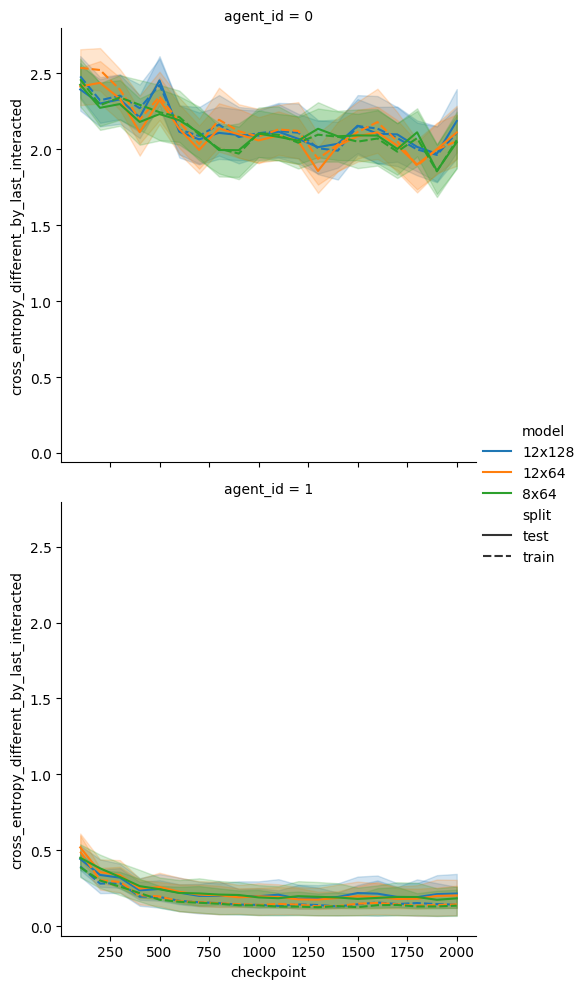

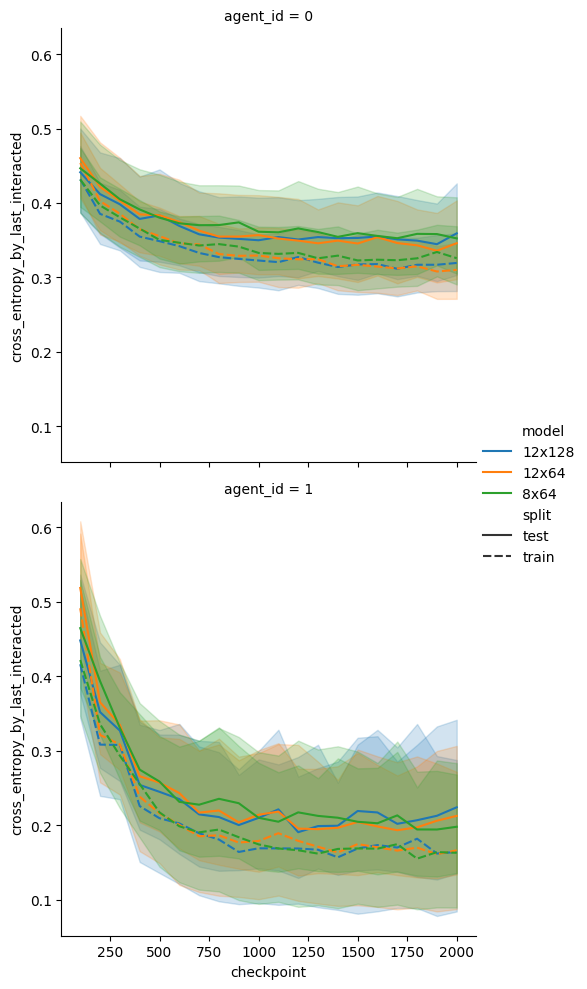

In [154]:
hue = "model"
# Columns of the facet grid. Can be None, which won't create separate columns.
col = None
# Parameters to use directly (if use_baseline_params is False) or to update the
# baseline params (if use_baseline_params is True).
update_params = {}  # {"sep_transformer": False}
use_baseline_params = True

if use_baseline_params:
    col_to_param_dict = BASELINE_PARAMS.copy()
    col_to_param_dict.update(update_params)
    # Allow multiple values for hue because we want to plot them.
    del col_to_param_dict[hue]
else:
    col_to_param_dict = update_params.copy()

assert hue not in col_to_param_dict

data = all_df.copy()
for key, value in col_to_param_dict.items():
    data = data[data[key] == value]

# If there are multiple runs per unique hue value, keep only the most recent run.
unique_run_data = []
group_cols = [hue] if col is None else [hue, col]
for key, group_df in data.groupby(group_cols):
    run_paths = group_df.run_path.unique()
    if len(run_paths) > 1:
        most_recent_run_path = max(
            run_paths, key=lambda p: datetime.strptime(p.parts[-2], "%Y-%m-%d_%H-%M-%S")
        )
        group_df = group_df[group_df.run_path == most_recent_run_path]
    unique_run_data.append(group_df)

unique_run_data = pd.concat(unique_run_data, ignore_index=True)

for metric in [
    "cross_entropy_different_by_last_interacted",
    "cross_entropy_by_last_interacted",
]:
    sns.relplot(
        data=unique_run_data,
        x="checkpoint",
        y=metric,
        row="agent_id",
        col=col,
        hue=hue,
        style="split",
        kind="line",
    )

In [ ]:
    sns.relplot(
        data=df,
        x="checkpoint",
        y=metric,
        row="agent_id",
        hue=x,
        style="split",
        kind="line",
    )

In [80]:
x = "max_seq_len"
plot_df = all_df.query(
    "model == '8x64' and sep_transformer"
)

for y in [
    "cross_entropy",
    "cross_entropy_different",
    "cross_entropy_by_last_interacted",
    "cross_entropy_different_by_last_interacted",
]:
    if "by_last_interacted" in y:
        data = plot_df
    else:
        data = plot_df[plot_df["agent_id"] == 0]

    # expected_unique_cols = {"episode", "agent_id", "split", x}
    # assert_df_is_not_duplicated(data, expected_unique_cols=expected_unique_cols)

    sns.catplot(
        data=data,
        kind="bar",
        x=x,
        order=[str(i) for i in [8, 16, 32, 64, 128]],
        y=y,
        hue="split",
        col="agent_id",
    )

AssertionError: 

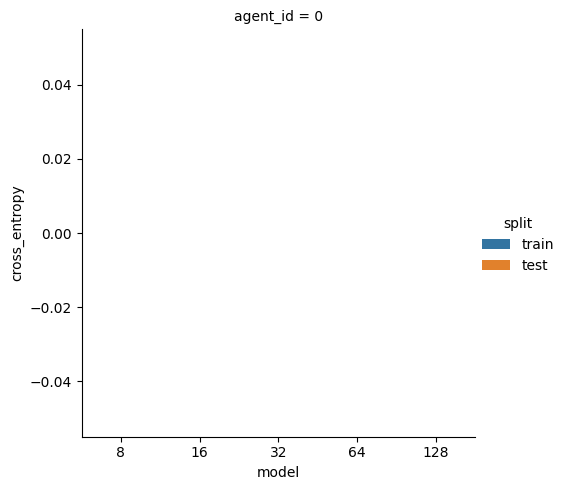

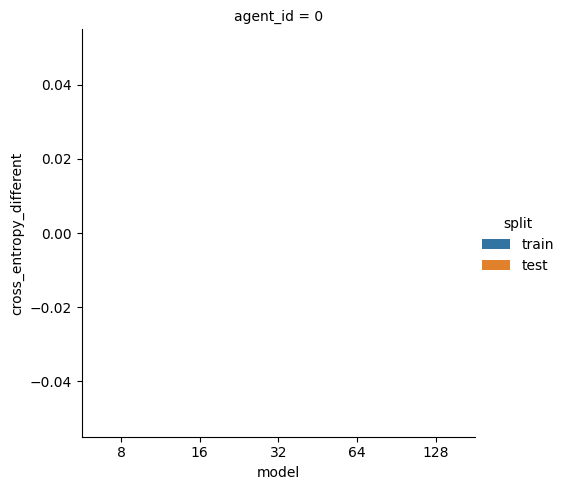

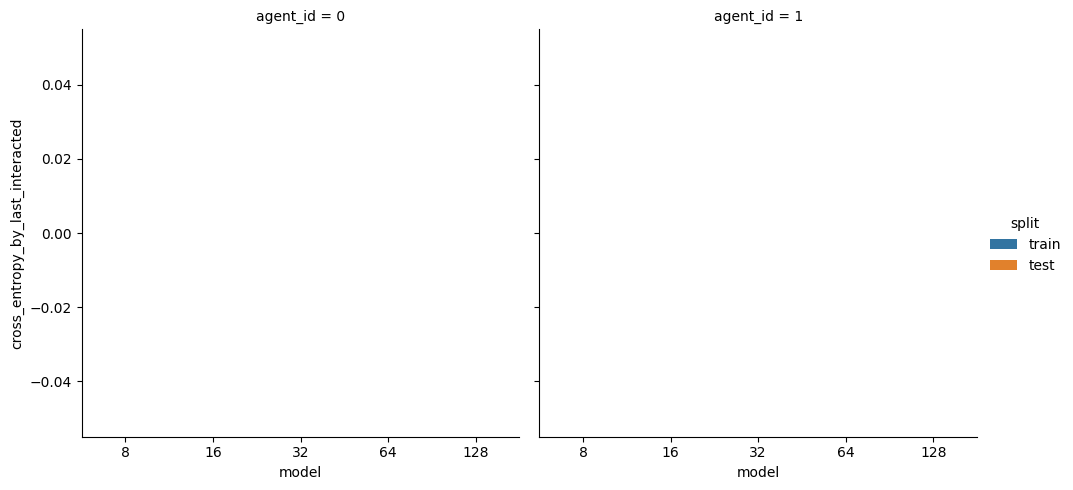

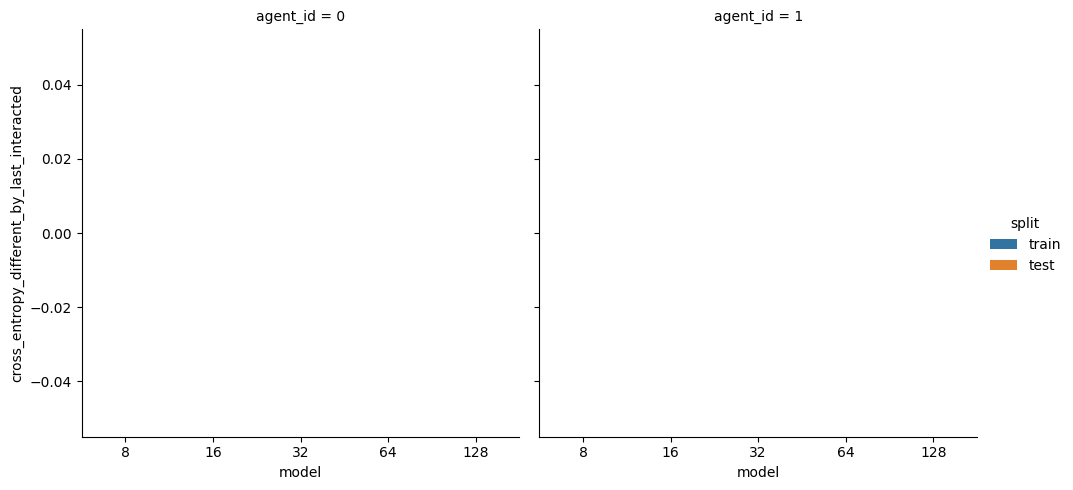

In [6]:
x = "model"
plot_df = all_df.query(
    "max_seq_len == '128' and sep_transformer and dim_feedforward == '64' and "
    "position_embedding_size == '18' and position_embedding_angle == '10000'"
)

for y in [
    "cross_entropy",
    "cross_entropy_different",
    "cross_entropy_by_last_interacted",
    "cross_entropy_different_by_last_interacted",
]:
    if "by_last_interacted" in y:
        data = plot_df
    else:
        data = plot_df[plot_df["agent_id"] == 0]

    # expected_unique_cols = {"episode", "agent_id", "split", x}
    # assert_df_is_not_duplicated(data, expected_unique_cols=expected_unique_cols)

    sns.catplot(
        data=data,
        kind="bar",
        x=x,
        order=[str(i) for i in [8, 16, 32, 64, 128]],
        y=y,
        hue="split",
        col="agent_id",
    )

In [81]:
for col in plot_df.columns:
    nunique = plot_df[col].nunique()
    if nunique > 1:
        print(col, nunique)

cross_entropy 800
cross_entropy_different 800
episode 50
agent_id 2
cross_entropy_by_last_interacted 1600
cross_entropy_different_by_last_interacted 1592
checkpoint 9
split 2
max_seq_len 4
dim_feedforward 3
position_embedding_size 2
position_embedding_angle 2


In [82]:
for col in ["dim_feedforward", "position_embedding_size", "position_embedding_angle"]:
    print(plot_df[col].unique())

['64' '256' '512']
['18' '144']
['10000' '10' nan]
